In [8]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

In [4]:
X_train = pd.read_csv("Data/X_train.csv")
y_train = pd.read_csv("Data/y_train.csv")

X_test = pd.read_csv("Data/X_test.csv")
y_test = pd.read_csv("Data/y_test.csv")

In [5]:
param_grid = {'max_depth': [4, 6, 8],
                'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                'reg_lambda':[0, 10, 100],
                'n_estimators':[1500, 3000],
                'gamma': [0, 5, 10],
                'subsample': [0.3, 0.5, 1.0],
                "colsample_bytree": [0.5, 0.75, 1.0]}

xgboost = RandomizedSearchCV(estimator = XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid,                             
                             verbose = 1,
                             n_jobs = -1,
                             cv = 5).fit(X_train, y_train)

xgboost.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'subsample': 0.3,
 'reg_lambda': 10,
 'n_estimators': 1500,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 1.0}

In [7]:
# No rounding
mean_squared_error(y_test, xgboost.predict(X_test))

0.43152105555261394

<Axes: ylabel='quality'>

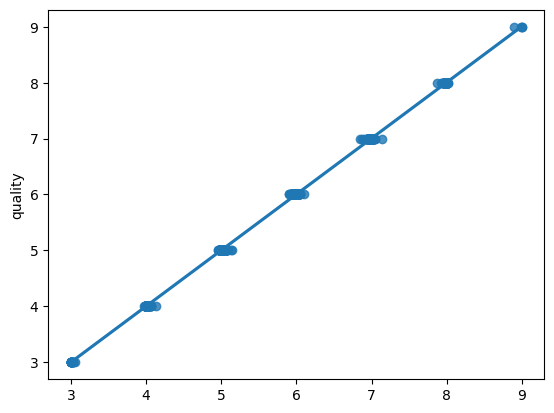

In [12]:
sns.regplot(x = xgboost.predict(X_train), y = y_train)

<Axes: ylabel='quality'>

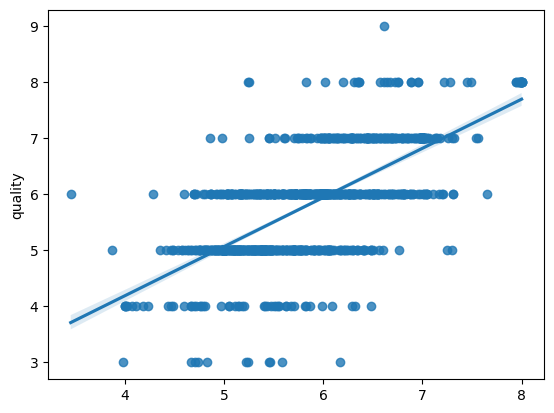

In [13]:
sns.regplot(x = xgboost.predict(X_test), y = y_test)

In [23]:
pred_series = pd.Series(xgboost.predict(X_test))
pred_series

0       5.169335
1       5.755543
2       6.002008
3       7.001436
4       6.983741
          ...   
1295    5.038090
1296    6.061346
1297    5.615932
1298    5.389737
1299    5.486078
Length: 1300, dtype: float32

In [24]:
pred_series_rounded = pred_series.round()

In [25]:
mean_squared_error(y_test, pred_series_rounded)

0.4807692307692308